In [2]:
import json
import os
from pathlib import Path

import numpy as np
import ogs
import ogstools as ot
import porepy as pp
import pyvista as pv
from IPython.display import Markdown, display
from numpy.random import default_rng
from scipy.stats import truncnorm

In [3]:
ot.plot.setup.show_Region_bounds = False

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

# Reactive transport and retention in stochastically generated DFNs: A PorePy–OpenGeoSys Workflow

---
# Motivation

Protecting the environment over geological timescales requires isolating hazardous substances (e.g., radionuclides and industrial chemicals) from the biosphere.  Accurate prediction of *solute transport* is essential for the safe design of deep geological repositories and for long-term groundwater contamination protection.

## Why is solute retention critical?

Natural retention processes — matrix diffusion and sorption — serve as critical barriers that delay contaminant migration, helping to prevent their spread through the environment.

 - **Matrix Diffusion**: The movement of solutes from regions of high to low concentration within a solid matrix, governed by concentration gradients and diffusion coefficients.

 - **Sorption**: The process by which solutes are retained on or in a solid, encompassing adsorption (solutes attaching to the surface) and absorption (solutes entering the solid matrix). This process is influenced by surface chemistry, solute properties, and environmental conditions, and is quantified by the distribution coefficient.


## How to study the solute retention?

**Tracer tests** are a primary method for investigating subsurface solute transport and retention.  In these experiments, a known tracer is injected into the formation, and its concentration is monitored over time at a recovery location.

<!-- > *Breakthrough curves — tracer concentration plotted versus time — reveal flow paths, dispersion, diffusion, and retention characteristics.* -->

Different tracers are used to isolate transport mechanisms:
- **Nonsorbing tracers** (e.g., tritiated water, bromide) reflect advective transport and matrix diffusion, providing information on physical transport mechanisms without chemical retention effects.
- **Sorption-active tracers** (e.g., strontium, cesium) additionally capture chemical retention through sorption.


## How to model the transport in fractured rock?

In crystalline rock formations, groundwater flow occurs primarily through *discrete fracture networks (DFN)*, as the rock matrix itself exhibits low permeability.  DFN models simulate flow and solute migration by treating fractures as discrete hydraulic features.


## How to numerically model it?

To investigate solute transport and retention in fractured rocks, a DFN is generated using `PorePy` with stochastic fracture placement algorithms.
The resulting DFN geometry is processed through `OGSTools` to create OpenGeoSys (OGS)-compatible input files, enabling the setup and execution of a Hydro-Component (HC) simulation for flow and solute transport, and retention in realistic fractured media.

---

# Problem description

![alt text](figs/schematic.png)

---
# Governing equations

This section presents the strong form of the governing equations used to describe fluid and component mass transport.
The model incorporates Darcy flow, advection, dispersion, linear equilibrium sorption, and first-order decay, all defined within a representative elementary volume (REV).


═════
### 1. General Conservation Principle


For any conserved quantity $u$ (e.g., fluid or component mass), the strong form of the conservation principle is:

$$
\frac{\partial s(u)}{\partial t} + \nabla \cdot \mathbf{J}(u) = Q
$$

where:

- $s(u)$ denotes the amount of $u$ stored per unit bulk volume $[\mathrm{kg}/\mathrm{m}^3]$,
- $\mathbf{J}(u)$ is the flux of $u$ through the porous medium $[\mathrm{kg}/\mathrm{m}^2\mathrm{s}]$,
- $Q$ is a volumetric source or sink term $[\mathrm{kg}/\mathrm{m}^3\mathrm{s}]$.


This general equation provides the foundation for both the fluid mass and component mass balance formulations.

═════
### 2. Conservation of Fluid Mass


The fluid mass stored per unit bulk volume is given by:

$$
s(m_\text{f}) = \phi \rho_\text{R}(p, \omega_\text{C})
$$

where:

- $\phi$: porosity $[-]$,
- $\rho_\text{R}$: fluid density $[\mathrm{kg}/\mathrm{m}^3]$, dependent on pressure $p$ and component mass fraction $\omega_\text{C}$.

Applying the chain rule to the time derivative of $\rho_\text{R}$:

$$
\frac{\partial \rho_\text{R}}{\partial t} = \frac{\partial \rho_\text{R}}{\partial p} \frac{\partial p}{\partial t} + \frac{\partial \rho_\text{R}}{\partial \omega_\text{C}} \frac{\partial \omega_\text{C}}{\partial t}
$$

Assuming fluid flow follows Darcy's law:

$$
\mathbf{q} = -\frac{\boldsymbol{\kappa}}{\mu} (\nabla p - \rho_\text{R} \mathbf{g})
$$

where:

- $\boldsymbol{\kappa}$: intrinsic permeability tensor $[\mathrm{m}^2]$,
- $\mu$: dynamic viscosity $[\mathrm{Pa \cdot s}]$,
- $\mathbf{g}$: gravitational acceleration vector $[\mathrm{m}/\mathrm{s}^2]$.

Substituting into the general conservation law yields the fluid mass balance equation:

$$
\phi \left( \frac{\partial \rho_\text{R}}{\partial p} \frac{\partial p}{\partial t} + \frac{\partial \rho_\text{R}}{\partial \omega_\text{C}} \frac{\partial \omega_\text{C}}{\partial t} \right) - \nabla \cdot \left( \frac{\boldsymbol{\kappa}}{\mu} \rho_\text{R} (\nabla p - \rho_\text{R} \mathbf{g}) \right) + Q_p = 0
\tag{1}
$$


═════
### 3. Conservation of Component Mass


The total component mass per unit bulk volume includes contributions from both the fluid and solid phases:

$$
s(m_\text{C}) = \phi \rho_\text{R} \omega_\text{C} + \rho_\text{S} \omega_\text{C}^{\text{solid}}
$$

Under linear equilibrium sorption:

$$
\omega_\text{C}^{\text{solid}} = K_\text{d} \omega_\text{C}
$$

Substituting gives:

$$
s(m_\text{C}) = (K_\text{d} \rho_\text{S} + \phi \rho_\text{R}) \omega_\text{C} = R \phi \rho_\text{R} \omega_\text{C}, \quad R = 1 + K_\text{d} \frac{\rho_\text{S}}{\phi \rho_\text{R}}
$$

where:
- $\omega_\text{C}$ is the component mass fraction in the fluid phase,
- $K_\text{d}$ is the linear distribution coefficient $[\mathrm{m}^3/\mathrm{kg}]$,
- $\rho_\text{S}$ is the bulk density of the solid matrix $[\mathrm{kg}/\mathrm{m}^3]$,
- $R$ is the retardation factor $[-]$.

The component flux includes both advective and dispersive contributions:

$$
\mathbf{J}(m_\text{C}) = \rho_\text{R} \omega_\text{C} \mathbf{v} - \rho_\text{R} \mathbf{D}_\text{h} \nabla \omega_\text{C}
$$

where the hydrodynamic dispersion tensor is:

$$
\mathbf{D}_\text{h} = \phi \left( D_\text{D} \mathbf{I} + \beta_\text{T} \|\mathbf{v}\| \mathbf{I} + (\beta_\text{L} - \beta_\text{T}) \frac{\mathbf{v} \otimes \mathbf{v}}{\|\mathbf{v}\|} \right)
$$

Incorporating first-order decay and coupling with fluid extraction/injection, the component mass balance becomes:

$$
\frac{\partial (R \phi \rho_\text{R} \omega_\text{C})}{\partial t} - \nabla \cdot \left( \rho_\text{R} \omega_\text{C} \mathbf{v} - \rho_\text{R} \mathbf{D}_\text{h} \nabla \omega_\text{C} \right) = Q_{\omega_\text{C}} - R \omega_\text{C} Q_p - R \theta \phi \rho_\text{R} \omega_\text{C}
\tag{2}
$$

where:
- $\theta$ is the first-order decay rate $[\mathrm{s}^{-1}]$,
- $Q_{\omega_\text{C}}$ is a source or sink of the component,
- $Q_p$ is the fluid phase source/sink that also affects the transported component.


═════
### 4. Stabilizers



In strongly advection-dominated transport problems (high local [Péclet number](https://en.wikipedia.org/wiki/Péclet_number), $\mathrm{Pe} = \frac{\|\mathbf{v}\|h}{2D} > 1$), the standard Galerkin finite element method often produces non-physical oscillations and negative concentrations. OpenGeoSys provides several stabilization options to mitigate these numerical instabilities:


####  [Isotropic Diffusion Stabilization](https://www.opengeosys.org/docs/benchmarks/hydro-thermal/classicaltransportexample_isotropic_diffusion_stb/)

Isotropic diffusion stabilization introduces an artificial diffusion tensor

$$
\mathbf{D}_\delta = \frac{1}{2} \alpha \|\mathbf{v}\| h \mathbf{I}, \quad \alpha \in [0,1],
$$

where $\|\mathbf{v}\|$ denotes the Darcy velocity magnitude, and  $h$ represents the characteristic element length.
The hydrodynamic dispersion tensor is then modified as

$$
\mathbf{D}_\text{h}^{\mathrm{stab}} = \mathbf{D}_\text{h} + \mathbf{D}_\delta.
$$

> Accordingly, the component mass balance equation substitutes $\mathbf{D}_\text{h}$ with $\mathbf{D}_\text{h}^{\mathrm{stab}}$.  By effectively enhancing diffusion, this strategy lowers the element Péclet number, thereby promoting numerical stability.



#### [Full Upwind Stabilization](https://doxygen.opengeosys.org/dc/d5e/ogs_file_param_prj_processes_process_numerical_stabilization_fullupwind)

The standard Galerkin method, which uses identical test and trial functions, leads to symmetric interpolation that treats upstream and downstream directions equally, causing non-physical oscillations in advection-dominated problems. In the full upwind approach, the original governing equations remain intact.  However, the discretized weak form of the advective term, $\nabla \cdot (\rho_\text{R} \omega_\text{C} \mathbf{v})$, is integrated by parts to obtain element residuals

$$
R_i = -\int_{\Omega_e} \nabla \phi_i \cdot (\rho_\text{R} \omega_\text{C} \mathbf{v}) \, d\Omega,
$$

where $\phi_i$ is the test function at node $i$.  Subsequently, local flux quantities

$$
q_i = -\int_{\Omega_e} \nabla \phi_i \cdot (\rho_\text{R} \mathbf{v}) \, d\Omega
$$

are computed to identify nodes as upwind ($ q_i > 0$) or downwind ($q_i < 0$).  The overall upwind and downwind fluxes are given by

$$
q_{\text{up}} = \sum_{q_i \geq 0} q_i \omega_{\text{C},i}, \quad q_{\text{down}} = -\sum_{q_i < 0} q_i.
$$

Element residuals are then approximated as

$$
\widetilde{R}_i =
\begin{cases}
q_i \omega_{\text{C},i}, & q_i \geq 0, \\
\frac{q_i}{q_{\text{down}}} q_{\text{up}}, & q_i < 0,
\end{cases}
$$

ensuring strict local mass conservation, $ \sum_i \widetilde{R}_i = 0$. This method redistributes fluxes based on residuals, improving stability in advection-dominated regimes without introducing artificial diffusion.


#### [Flux corrected transport](https://www.opengeosys.org/docs/benchmarks/hydro-component/flux_Corrected_transport/)

To overcome non-physical oscillations and negative concentrations, the Flux Corrected Transport (FCT) stabilization method combines a high-order solution with a controlled low-order monotone solution (stable but diffusive), ensuring numerical stability without significantly sacrificing accuracy.

##### Crank–Nicolson time discretization

The FCT method utilizes the Crank–Nicolson scheme for temporal discretization. This scheme discretizes any time-dependent quantity $f$ at the midpoint between time steps $n$ and $n+1$:

$$
f^{n+\frac{1}{2}} = h f^{n+1} + (1 - h) f^{n}, \quad h = 0.5.
$$

Applying this discretization to the component mass balance equation (Eq. (2)) gives the algebraic form:


$$
\frac{R \phi \rho_\text{R}}{\Delta t}\mathbf{M}\omega_\text{C}^{n+1}-\frac{R \phi \rho_\text{R}}{\Delta t}\mathbf{M}\omega_\text{C}^{n} + h\mathbf{K}\omega_\text{C}^{n+1}+(1 - h)\mathbf{K}\omega_\text{C}^{n}=\mathbf{Q}_{\omega_\text{C}}^{n+\frac{1}{2}},
$$

where $\mathbf{M}$ is the consistent mass matrix, $\mathbf{K}$ is the conductance (flux) matrix.

##### FCT implementation steps**

I. **High-order solution (original Galerkin FEM)**:

Solve the original algebraic equation to obtain a preliminary solution $\omega_\text{C}^{n+1,*}$:

$$
\left(\frac{R \phi \rho_\text{R}}{\Delta t}\mathbf{M}+h\mathbf{K}\right)\omega_\text{C}^{n+1,*}
= \left(\frac{R \phi \rho_\text{R}}{\Delta t}\mathbf{M}-(1-h)\mathbf{K}\right)\omega_\text{C}^{n}.
$$

II. **Low-order monotone solution (stable, diffusive)**:

To ensure monotonicity, replace $\mathbf{M}$ by lumped mass $\mathbf{M}_\text{L}$ and introduce artificial diffusion tensor $\mathbf{D}_\delta$:

$$
D_{\delta,ij}=\max(0,-K_{ij},-K_{ji}),\quad i\neq j,\quad D_{\delta,ii}=-\sum_{j\neq i}D_{\delta,ij}.
$$

Then solve the low-order equation:

$$
\left(\frac{R\phi\rho_\text{R}}{\Delta t}\mathbf{M}_\text{L}+h(\mathbf{K}+\mathbf{D}_\delta)\right)\omega_\text{C}^{n+1}
=\left(\frac{R\phi\rho_\text{R}}{\Delta t}\mathbf{M}_\text{L}-(1-h)(\mathbf{K}+\mathbf{D}_\delta)\right)\omega_\text{C}^{n}.
$$

III. **Anti-diffusive flux correction**:

Compute anti-diffusive fluxes $f_{ij}$:

$$
f_{ij}=m_{ij}\left(\omega_{\text{C},i}^{n+1,*}-\omega_{\text{C},j}^{n+1,*}\right)-h\,D_{\delta,ij}\left(\omega_{\text{C},i}^{n+1}-\omega_{\text{C},j}^{n+1}\right)-(1-h)\,D_{\delta,ij}\left(\omega_{\text{C},i}^{n}-\omega_{\text{C},j}^{n}\right),
$$

limit them ($a_{ij}\in[0,1]$) to maintain positivity and monotonicity:

$$
\bar{f}_{ij}=a_{ij}f_{ij}.
$$

IV. **Final corrected FCT solution**:

Solve for the corrected solution $\omega_\text{C}^{n+1}$:

$$
\left(\frac{R\phi\rho_\text{R}}{\Delta t}\mathbf{M}_\text{L}+h(\mathbf{K}+\mathbf{D}_\delta)\right)\omega_\text{C}^{n+1}
=\left(\frac{R\phi\rho_\text{R}}{\Delta t}\mathbf{M}_\text{L}-(1-h)(\mathbf{K}+\mathbf{D}_\delta)\right)\omega_\text{C}^{n}+\bar{\mathbf{f}},
$$

with anti-diffusive flux at node $i$:

$$
\bar{f}_i=\sum_{j\neq i}\bar{f}_{ij}.
$$

V. **Stability condition** (CFL-type restriction):

The timestep $\Delta t$ must satisfy:

$$
\Delta t\leq\frac{m_{\text{L},i}}{(1-h)K_{ii}},\quad\text{for all nodes } i.
$$

---

# DFN generating using Porepy

**PorePy** is an open-source Python library developed by the University of Bergen, designed for simulating multiphysics processes in fractured and porous media. It emphasizes discrete fracture network (DFN) modeling through a mixed-dimensional approach.

- Official site: [PorePy at University of Bergen](https://www.uib.no/en/rg/pmg/143656/porepy)
- Source code: [PorePy GitHub Repository](https://github.com/pmgbergen/porepy)

### Installation

Install PorePy within the same virtual environment as OGS:

```bash
pip install porepy
```

For full installation instructions, see the [PorePy Installation Guide](https://github.com/pmgbergen/porepy/blob/develop/Install.md).



### Input data

In [7]:
domain_size = 100.0
mesh_size_boundary = 0.1 * domain_size
mesh_size_fracture = 0.05 * domain_size
mesh_size_min = 0.01 * domain_size

### Domain seteup
Defines the minimum and maximum coordinates of a 3D cubic domain.

In [8]:
mins = np.array([0.0, 0.0, 0.0])
maxs = np.array([domain_size, domain_size, domain_size])
bounding_box = {
    "xmin": mins[0],
    "xmax": maxs[0],
    "ymin": mins[1],
    "ymax": maxs[1],
    "zmin": mins[2],
    "zmax": maxs[2],
}
domain = pp.Domain(bounding_box=bounding_box)


### Fracture generation loop

- The loop iterates `n_fractures` times, with each iteration generating a single fracture.
- For every fracture:
  - A `random center` is generated within the domain by scaling a uniformly distributed random vector.
  - A `random radius` is selected within the `radius_\text{R}ange`, setting its size between the allowed minimum and maximum values.
  - Both the `major axis` and `minor axis` are set equal to the radius—while PorePy supports ellipses, we're using circular fractures here.
  - `Strike and dip angles` are randomly drawn from the interval $[-\frac{\pi}{2}, \frac{\pi}{2}]$.
    - These angles define the fracture plane's orientation (see [link](https://github.com/pmgbergen/porepy/blob/main/src/porepy/fracs/plane_fracture.py)):
      - **Strike angle**: Sets the direction of the rotation axis in the horizontal plane, measured from the x-axis.
      - **Dip angle**: Describes the tilt of the fracture plane from the horizontal.

In [9]:
use_saved_fractures = True
fracture_params_file = Path("fracture_params.json")
fracture_params_path = Path(out_dir, "fracture_params.json")
radius_range = np.array([50, 80])
n_fractures = 10

# borehole
borehole_height = 60
borehole_radius = maxs[0] * 0.005  # radius in x/y
z_center = maxs[2]
y_center = 0.5 * (mins[1] + maxs[1])
x_left = 0.2 * maxs[0]
x_right = 0.8 * maxs[0]

In [10]:
fractures = []
if use_saved_fractures and fracture_params_file.exists():
    fracture_params = json.loads(fracture_params_file.read_text())
    print("Loaded existing fracture parameters.")
else:
    rng = default_rng(12345)
    fracture_params = []
    for _ in range(n_fractures):
        center = rng.random(3) * (maxs - mins) + mins

        radius = rng.random() * (radius_range[1] - radius_range[0]) + radius_range[0]
        major_axis = minor_axis = radius

        major_axis_angle = rng.uniform(0, 2 * np.pi)
        strike_angle = rng.uniform(-0.5 * np.pi, 0.5 * np.pi)
        dip_angle = rng.uniform(-0.5 * np.pi, 0.5 * np.pi)

        fracture_params.append(
            {
                "center": center.tolist(),
                "major_axis": major_axis,
                "minor_axis": minor_axis,
                "major_axis_angle": major_axis_angle,
                "strike_angle": strike_angle,
                "dip_angle": dip_angle,
            }
        )

    fracture_params_file.write_text(json.dumps(fracture_params, indent=4))
    print("New fracture parameters generated and saved explicitly.")

for p in fracture_params:
    frac = pp.create_elliptic_fracture(
        center=np.array(p["center"]),
        major_axis=p["major_axis"],
        minor_axis=p["minor_axis"],
        major_axis_angle=p["major_axis_angle"],
        strike_angle=p["strike_angle"],
        dip_angle=p["dip_angle"],
    )
    fractures.append(frac)


#  vertical boreholes as long, thin fractures
center_left = np.array([x_left, y_center, z_center])
borehole_left = pp.create_elliptic_fracture(
    center=center_left,
    major_axis=borehole_height,
    minor_axis=borehole_radius,
    major_axis_angle=np.pi / 2,
    strike_angle=0.0,
    dip_angle=-0.5 * np.pi,
)
fractures.append(borehole_left)

center_right = np.array([x_right, y_center, z_center])
borehole_right = pp.create_elliptic_fracture(
    center=center_right,
    major_axis=borehole_height,
    minor_axis=borehole_radius,
    major_axis_angle=np.pi / 2,
    strike_angle=0.0,
    dip_angle=-0.5 * np.pi,
)
fractures.append(borehole_right)

Loaded existing fracture parameters.


### Fracture network generation

Once all fractures are generated, they're passed as a list to `create_fracture_network()`, along with the domain's bounding box. This creates a 3D Fracture Network object, representing the full 3D fracture system. The object takes care of intersection detection, applies the orientation from strike/dip angles, and prepares the geometry for meshing and simulation (see [FractureNetwork3d documentation](https://pmgbergen.github.io/porepy/html/docsrc/porepy/porepy.fracs.fracture_network_3d.html)).

The system consists of two vertical fractures representing inlet and outlet boreholes, modeled as long, thin elliptic fractures. The minor axis is set to a small value (`borehole_Radius = maxs[0] * 0.005`) to reflect the narrow borehole dimensions.
1. **Left Borehole**: Located at `[x_Left, y_Center, zmax]`, with a major axis of `borehole_height` and a minor axis of `borehole_Radius`, oriented vertically (`major_axis_angle =`$\frac{\pi}{2}$, `dip_angle =`$\frac{\pi}{2}$).
2. **Right Borehole**: Located at `[x_Right, y_Center, zmax]`, with identical dimensions and orientation as the left borehole.

Both fractures are added to the `fractures` list.


In [104]:
network = pp.create_fracture_network(fractures=fractures, domain=domain)

### Meshing the fracture network

We generate the computational mesh using PorePy's mixed-dimensional approach:

- `cell_size_boundary`: maximum cell size near the domain boundaries.
- `cell_size_fracture`: target cell size along the fracture surfaces.
- `cell_size_min`: minimum allowed cell size anywhere in the mesh.
- `simplex`: enables triangular (2D) or tetrahedral (3D) elements.

This produces a **mixed-dimensional grid (`mdg`)** with 3D rock matrix cells, 2D fracture surfaces, and lower-dimensional intersections.

For fracture-only simulations, the 3D matrix is removed, leaving just the 2D fractures and their intersections.

In [105]:
mesh_args = {
    "cell_size_boundary": mesh_size_boundary,
    "cell_size_fracture": mesh_size_fracture,
    "cell_size_min": mesh_size_min,
    "export": True,
    "filename": "mdg2d",
    # "folder_name": out_dir,
}
mdg = pp.create_mdg("simplex", mesh_args, network)

# Removal of domain (3D) cells
mdg2d = mdg.copy()
for sd in mdg2d.subdomains():
    if sd.dim == 3:
        mdg2d.remove_subdomain(sd)

## Export the mesh to VTU format

Creates a VTK file of the 2D mixed-dimensional grid (mdg2d) using `Exporter` (see [link](https://pmgbergen.github.io/porepy/html/docsrc/porepy/porepy.viz.exporter.html#module-porepy.viz.exporter)). The output is compatible with visualization tools like ParaView, and serves as input for OpenGeoSys.

In [106]:
exporter = pp.Exporter(mdg2d, "mixed_dimensional_grid", folder_name=out_dir).write_vtu()

--------

# OpenGeosys

#### Preparing the mesh (`.vtu`) for OpenGeosys simulation
We generate s clean, standardized `.vtu` mesh containing only `MaterialIDs` as cell data — fully tailored for **OpenGeoSys** simulations in fractured media.

- Loads the `.vtu` file into a mesh object for processing.
- If `MaterialIDs` are missing, they're generated from `subdomain_id`, starting at 0 —  OGS uses them to identify physical regions.
- Removes all other cell and point data, keeping only what's necessary for OGS.
- Saves the meshes ready for use in an OGS `.prj` setup.

In [107]:
DFN_2D = ot.Mesh(f"{out_dir}/mixed_dimensional_grid_2.vtu")
if "MaterialIDs" not in DFN_2D.cell_data:
    DFN_2D["MaterialIDs"] = (
        DFN_2D["subdomain_id"] - DFN_2D["subdomain_id"].min()
    ).astype(np.int32)
DFN_2D.save(f"{out_dir}/mixed_dimensional_grid_constant_2.vtu")

In [108]:
DFN_2D = ot.Mesh(f"{out_dir}/mixed_dimensional_grid_constant_2.vtu")
if "MaterialIDs" not in DFN_2D.cell_data:
    DFN_2D["MaterialIDs"] = (
        DFN_2D["subdomain_id"] - DFN_2D["subdomain_id"].min()
    ).astype(np.int32)

for key in list(DFN_2D.cell_data):
    if key != "MaterialIDs":
        DFN_2D.cell_data.remove(key)

for key in list(DFN_2D.point_data):
    DFN_2D.point_data.remove(key)


DFN_2D.save(f"{out_dir}/mixed_dimensional_grid_constant_2.vtu")

In [109]:
orig_dir = Path.cwd()
%cd {out_dir}
ogs.cli.reviseMesh(i="mixed_dimensional_grid_constant_2.vtu", o="temp.vtu")
ogs.cli.NodeReordering(i="temp.vtu", o="mixed_dimensional_grid_constant_2.vtu")
ogs.cli.checkMesh("mixed_dimensional_grid_constant_2.vtu", v=True)

/home/mok/ogs/Tests/Data/Parabolic/ComponentTransport/DFN_PorePy/_out
[2025-06-03 13:57:53.960] [ogs] [info] Mesh read: 12110 nodes, 20662 elements.
[2025-06-03 13:57:53.960] [ogs] [info] Simplifying the mesh...
[2025-06-03 13:57:53.978] [ogs] [warning] Property MaterialIDs exists but does not have the requested mesh item type node.
[2025-06-03 13:57:53.978] [ogs] [warning] Property MaterialIDs exists but does not have the requested type f.
[2025-06-03 13:57:53.978] [ogs] [warning] Property MaterialIDs exists but does not have the requested type d.
[2025-06-03 13:57:54.009] [ogs] [info] Revised mesh: 10340 nodes, 20662 elements.
[2025-06-03 13:57:54.055] [ogs] [info] Reordering nodes... 
[2025-06-03 13:57:54.056] [ogs] [info] Corrected 10360 elements.
[2025-06-03 13:57:54.069] [ogs] [info] VTU file written.
[2025-06-03 13:57:54.130] [ogs] [info] Memory size: 4 MiB
[2025-06-03 13:57:54.131] [ogs] [info] Time for reading: 0.0462273 s
[2025-06-03 13:57:54.131] [ogs] [info] Axis aligned bo

0

## Boundary and materials extraction using OpenGeoSys tools

- **[`ExtractBoundary`](https://www.opengeosys.org/docs/tools/meshing-submeshes/extract-boundary/)**  Extracts all outer surface faces from a 3D mesh and creates a boundary-only mesh. Useful for defining where boundary conditions will be applied.

- **[`RemoveMeshElements`](https://www.opengeosys.org/docs/tools/meshing/remove-mesh-elements/)**  Removes elements based on coordinate filters (e.g., x-min, x-max). Used to isolate specific boundary patches for inflow/outflow or other localized conditions.

- **[`ExtractMaterials`](https://www.opengeosys.org/docs/tools/meshing-submeshes/extractmaterials/)** Extracts submeshes from a mesh by selecting elements with specific material IDs, enabling features such as boreholes, fractures, or layers to be used for boundary conditions.


In [110]:
boundary_tol_fraction = 1e-6  # Tolerance for boundary selection
boundary_tol = boundary_tol_fraction * domain_size
x_outlet = maxs[0] - boundary_tol
x_inlet = mins[0] + boundary_tol

In [111]:
ogs.cli.ExtractBoundary(i="mixed_dimensional_grid_constant_2.vtu", o="boundaries.vtu")
ogs.cli.removeMeshElements(i="boundaries.vtu", o="x_inlet.vtu", **{"x-min": x_inlet})
ogs.cli.removeMeshElements(
    i="boundaries.vtu", o="x_outlet.vtu", **{"x-min": x_outlet, "invert": True}
)

[2025-06-03 13:58:00.149] [ogs] [info] Mesh read: 10340 nodes, 20662 elements.
[2025-06-03 13:58:00.150] [ogs] [info] 1 property vectors copied, 0 vectors skipped.
[2025-06-03 13:58:00.150] [ogs] [info] Created surface mesh: 1132 nodes, 1154 elements.
[2025-06-03 13:58:00.169] [ogs] [info] Mesh read: 1132 nodes, 1154 elements.
[2025-06-03 13:58:00.169] [ogs] [info] Bounding box of "boundaries" is
x = [-0.000000,100.000000]
y = [0.000000,100.000000]
z = [0.000000,100.000000]
[2025-06-03 13:58:00.169] [ogs] [info] 988 elements found.
[2025-06-03 13:58:00.169] [ogs] [info] Removing total 988 elements...
[2025-06-03 13:58:00.169] [ogs] [info] 166 elements remain in mesh.
[2025-06-03 13:58:00.169] [ogs] [info] Removing total 967 nodes...
[2025-06-03 13:58:00.182] [ogs] [info] Mesh read: 1132 nodes, 1154 elements.
[2025-06-03 13:58:00.182] [ogs] [info] Bounding box of "boundaries" is
x = [-0.000000,100.000000]
y = [0.000000,100.000000]
z = [0.000000,100.000000]
[2025-06-03 13:58:00.182] [ogs

0

In [112]:
ogs.cli.ExtractMaterials(
    i="mixed_dimensional_grid_constant_2.vtu", o="borehole_right.vtu", m=n_fractures
)
ogs.cli.ExtractMaterials(
    i="mixed_dimensional_grid_constant_2.vtu", o="borehole_left.vtu", m=n_fractures + 1
)
ogs.cli.identifySubdomains(
    "-m",
    "mixed_dimensional_grid_constant_2.vtu",
    "-s",
    str(1e-6),
    "--",
    f"borehole_left_Layer{n_fractures+1}.vtu",
    f"borehole_right_Layer{n_fractures}.vtu",
)

[2025-06-03 13:58:00.296] [ogs] [info] Extracting material group 10...
[2025-06-03 13:58:00.297] [ogs] [info] Removing total 20490 elements...
[2025-06-03 13:58:00.297] [ogs] [info] 172 elements remain in mesh.
[2025-06-03 13:58:00.298] [ogs] [info] Removing total 10192 nodes...
[2025-06-03 13:58:00.336] [ogs] [info] Extracting material group 11...
[2025-06-03 13:58:00.336] [ogs] [info] Removing total 20512 elements...
[2025-06-03 13:58:00.336] [ogs] [info] 150 elements remain in mesh.
[2025-06-03 13:58:00.337] [ogs] [info] Removing total 10206 nodes...
[2025-06-03 13:58:00.370] [ogs] [info] Mesh reading time: 0.0185573 s
[2025-06-03 13:58:00.371] [ogs] [info] MeshNodeSearcher construction time: 0.00100179 s
[2025-06-03 13:58:00.371] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 5.0084e-05 s
[2025-06-03 13:58:00.378] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 0.00722183 s
[2025-06-03 13:58:00.379] [ogs] [info] identifySubdomainMesh(

0

## Plot DFN and boundaries

[Errno 2] No such file or directory: '$orig_dir'
/home/mok/ogs/Tests/Data/Parabolic/ComponentTransport/DFN_PorePy


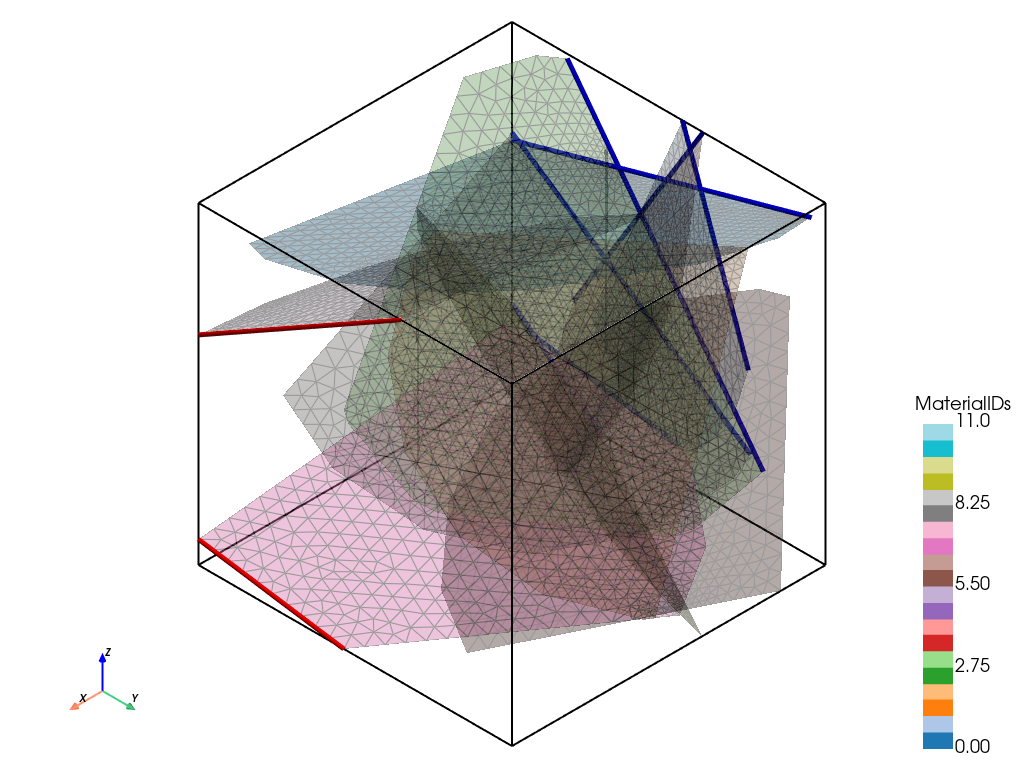

In [18]:
%cd $orig_dir
try:
    pv.set_jupyter_backend("static")
except Exception as e:
    print("PyVista backend not set:", e)

DFN_2D = pv.read(f"{out_dir}/mixed_dimensional_grid_constant_2.vtu")
x_inlet = pv.read(f"{out_dir}/x_inlet.vtu")
x_outlet = pv.read(f"{out_dir}/x_outlet.vtu")

plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(
    DFN_2D,
    scalars="MaterialIDs",
    cmap="tab20",
    opacity=0.4,
    show_edges=True,
    scalar_bar_args={"title": "MaterialIDs", "vertical": True},
)
plotter.add_mesh(DFN_2D.outline(), color="black", line_width=2)
plotter.add_mesh(
    x_inlet,
    color="blue",
    opacity=1.0,
    show_edges=False,
    line_width=5,
    render_lines_as_tubes=True,
)
plotter.add_mesh(
    x_outlet,
    color="red",
    opacity=1.0,
    show_edges=False,
    line_width=5,
    render_lines_as_tubes=True,
)

plotter.show_axes()
plotter.enable_parallel_projection()
plotter.view_isometric()
# plotter.window_size = [500, 500]
output_path = out_dir.joinpath("Concentration.png")
plotter.screenshot(str(output_path))
plotter.show()

## Generate and assign random fracture properties with Gaussian distributions

We assign random fracture properties (e.g., width and permeability) by calculating each mean value, $\mu$, from one of three user-defined distributions: [Uniform](https://en.wikipedia.org/wiki/Uniform_distribution_%28continuous%29), [clipped Gaussian](https://en.wikipedia.org/wiki/Normal_distribution), or [truncated Gaussian](https://en.wikipedia.org/wiki/Truncated_normal_distribution), constrained within specified bounds. The standard deviation is then calculated as $\sigma = \mathrm{rel_{std}} \times \mu$, with $\mathrm{rel_{std}}$ fixed at 30\%, and  cell values are subsequently sampled from a Gaussian distribution $\bigl(\mu, \sigma\bigr)$ and mapped to the mesh. Permeability can be configured as either isotropic or anisotropic.

In [19]:
def sample_truncnorm(a, b, mu, sigma, size=None):
    a_std, b_std = (a - mu) / sigma, (b - mu) / sigma
    return truncnorm.rvs(a_std, b_std, loc=mu, scale=sigma, size=size)


def sample_mean(a, b, method="uniform"):
    rng = default_rng()
    if method == "uniform":
        return rng.uniform(a, b)

    if method == "constant":
        return 0.5 * (a + b)

    mu = 0.5 * (a + b)
    sigma = (b - a) / 6.0

    if method == "gaussian":
        return np.clip(rng.normal(mu, sigma), a, b)
    if method == "truncated":
        return sample_truncnorm(a, b, mu, sigma)

    msg = "Unknown sampling method"
    raise ValueError(msg)


def generate_random_fracture_stats(
    fracture_ids,
    width_range=(5e-6, 1e-5),
    k_range=(1e-14, 1e-12),
    rel_std=0.3,
    mean_dist="uniform",
):
    stats = {}

    for mat_id in fracture_ids:
        w_min, w_max = width_range
        width_mean = sample_mean(w_min, w_max, method=mean_dist)
        k_min, k_max = k_range
        k_mean = sample_mean(k_min, k_max, method=mean_dist)

        stats[mat_id] = {
            "width_mean": width_mean,
            "width_std": rel_std * width_mean,
            "width_range": (w_min, w_max),
            "k_mean": k_mean,
            "k_std": rel_std * k_mean,
            "k_range": (k_min, k_max),
            "method": mean_dist,
        }

    return stats


def assign_cellwise_random_props(mesh, stats_dict, clip_min=1e-20, seed=42):
    MaterialIDs = mesh.cell_data["MaterialIDs"]
    n_cells = len(MaterialIDs)
    width_ic = np.zeros(n_cells)
    permeability_tensor = np.zeros((n_cells, 9))
    rng = default_rng(seed)

    for mat_id, stats in stats_dict.items():
        idx = np.where(MaterialIDs == mat_id)[0]
        n = len(idx)

        method = stats.get("method", "uniform")

        w_min, w_max = stats["width_range"]
        w_mean, w_std = stats["width_mean"], stats["width_std"]
        k_min, k_max = stats["k_range"]
        k_mean, k_std = stats["k_mean"], stats["k_std"]

        if method == "uniform":
            width_vals = rng.uniform(w_min, w_max, n)
            k_vals = rng.uniform(k_min, k_max, n)
        elif method == "constant":
            width_vals = np.full(n, w_mean)
            k_vals = np.full(n, k_mean)
        elif method == "truncated":
            width_vals = sample_truncnorm(w_min, w_max, w_mean, w_std, size=n)
            k_vals = sample_truncnorm(k_min, k_max, k_mean, k_std, size=n)
        elif method == "gaussian":
            width_vals = np.clip(rng.normal(w_mean, w_std, n), w_min, w_max)
            k_vals = np.clip(rng.normal(k_mean, k_std, n), k_min, k_max)
        else:
            msg = "Unknown sampling method"
            raise ValueError(msg)

        width_ic[idx] = np.clip(width_vals, clip_min, None)
        permeability_tensor[idx, 0] = k_vals
        permeability_tensor[idx, 4] = k_vals
        permeability_tensor[idx, 8] = k_vals

    mesh.cell_data["width_ic"] = width_ic
    mesh.cell_data["permeability_ic"] = permeability_tensor

In [50]:
input_mesh = "mixed_dimensional_grid_constant_2.vtu"
output_mesh = "mixed_dimensional_grid_constant_2_updated.vtu"
use_isotropic_perm = False

mesh = pv.read(Path(out_dir, input_mesh))

material_ids = np.unique(mesh.cell_data["MaterialIDs"])
fracture_ids = list(material_ids)

In [88]:
fracture_stats = generate_random_fracture_stats(
    fracture_ids,
    width_range=(1e-6, 1e-5),
    k_range=(1e-16, 1e-14),
    rel_std=0.3,  # standard deviation is 30 % of mean value.
    mean_dist="gaussian",  # constant, uniform, gaussian, or truncated
)
assign_cellwise_random_props(mesh, fracture_stats)
mesh.save(Path(out_dir, output_mesh), binary=False)

In [89]:
base_scalar_bar_args = {
    "vertical": True,
    "position_x": 0.9,
    "position_y": 0.2,
    "width": 0.03,
    "height": 0.6,
    "title_font_size": 20,
    "label_font_size": 16,
    "n_labels": 4,
    "color": "black",
    "fmt": "%.1f",
}

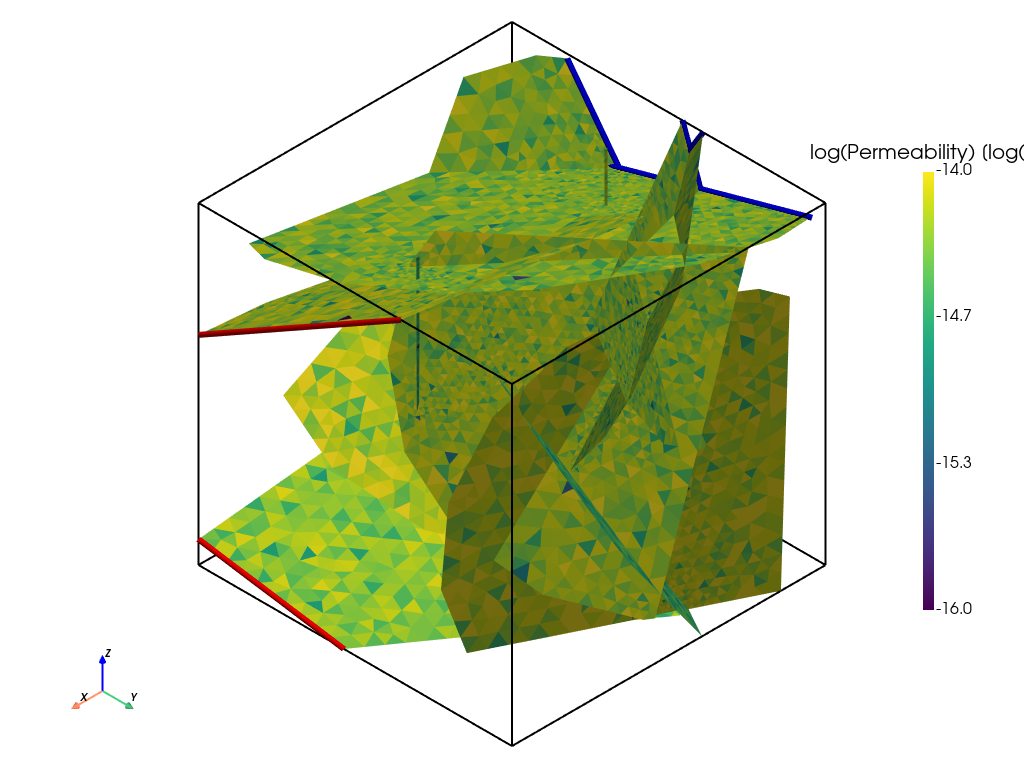

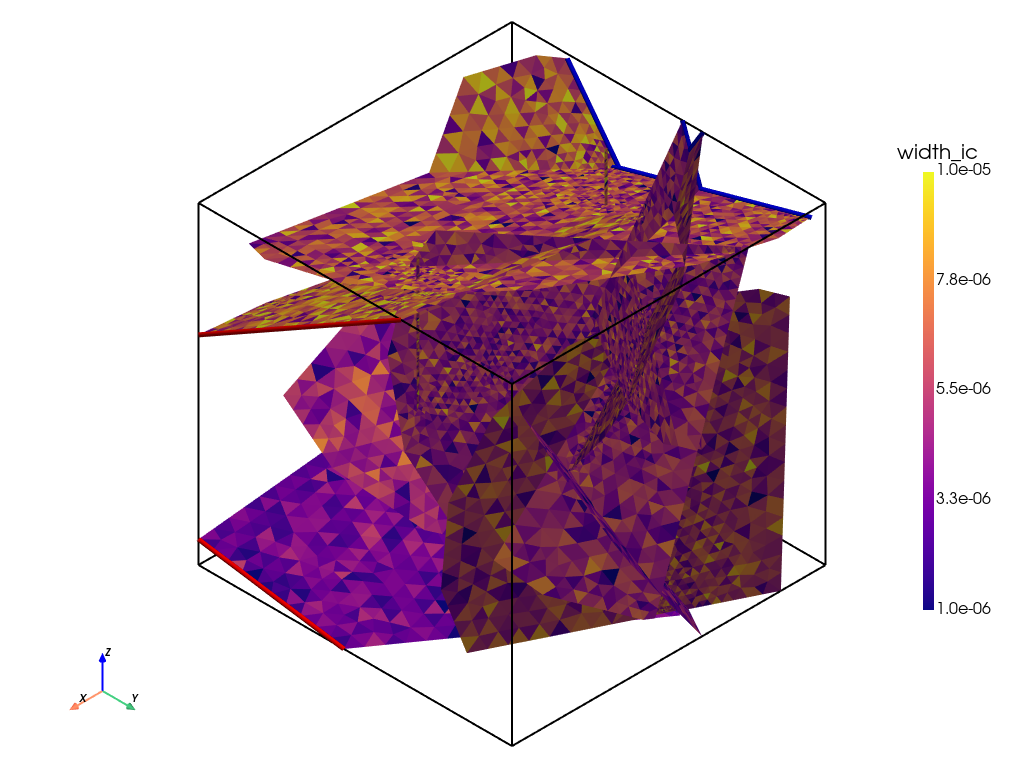

In [90]:
try:
    pv.set_jupyter_backend("static")
except Exception as e:
    print("PyVista backend not set:", e)

DFN_2D = pv.read(Path(out_dir, output_mesh))
x_inlet = pv.read(Path(out_dir, "x_inlet.vtu"))
x_outlet = pv.read(Path(out_dir, "x_outlet.vtu"))


def plot_scalar_field(mesh, inlet, outlet, scalar_data, title, cmap, filename):
    scalar_bar_args = base_scalar_bar_args.copy()
    scalar_bar_args["title"] = title

    scalar_bar_args = base_scalar_bar_args.copy()
    scalar_bar_args.update(
        {
            "fmt": "%.1e",  # Scientific notation
            "n_labels": 5,  # More labels to show range
        }
    )

    plotter = pv.Plotter(off_screen=True)
    plotter.add_mesh(
        mesh,
        scalars=scalar_data,
        cmap=cmap,
        show_edges=False,
        scalar_bar_args=scalar_bar_args,
    )
    plotter.add_mesh(mesh.outline(), color="black", line_width=2)
    plotter.add_mesh(inlet, color="blue", line_width=5, render_lines_as_tubes=True)
    plotter.add_mesh(outlet, color="red", line_width=5, render_lines_as_tubes=True)
    plotter.show_axes()
    plotter.enable_parallel_projection()
    plotter.view_isometric()
    plotter.screenshot(Path(out_dir, filename))
    plotter.show()


def plot_isotropic_permeability(
    mesh,
    inlet,
    outlet,
    out_dir,
    cmap="viridis",
    image_name="permeability_isotropic.png",
):
    k_iso = mesh.cell_data["permeability_ic"][:, 0]
    k_log = np.log10(np.clip(k_iso, 1e-20, None))
    mesh.cell_data["log_k_iso"] = k_log

    scalar_bar_args = base_scalar_bar_args.copy()
    scalar_bar_args["title"] = "log₁₀(Permeability) [log₁₀(m²)]"

    plotter = pv.Plotter(off_screen=True)
    plotter.add_mesh(
        mesh,
        scalars="log_k_iso",
        cmap=cmap,
        show_edges=False,
        scalar_bar_args=scalar_bar_args,
    )
    plotter.add_mesh(mesh.outline(), color="black", line_width=2)
    plotter.add_mesh(inlet, color="blue", line_width=6, render_lines_as_tubes=True)
    plotter.add_mesh(outlet, color="red", line_width=6, render_lines_as_tubes=True)
    plotter.view_isometric()
    plotter.enable_parallel_projection()
    plotter.show_axes()
    plotter.screenshot(Path(out_dir, image_name))
    plotter.show()


plot_isotropic_permeability(
    mesh=DFN_2D,
    inlet=x_inlet,
    outlet=x_outlet,
    out_dir=out_dir,
)

plot_scalar_field(
    mesh=DFN_2D,
    inlet=x_inlet,
    outlet=x_outlet,
    scalar_data="width_ic",
    title="Fracture Width (m)",
    cmap="plasma",
    filename="width_ic.png",
)

## Project file preparation

In [91]:
def add_component_to_model(
    model, name, pore_diff="1e-9", retardation="1.0", decay="0.0"
):
    # Add <component>
    model.add_element(".//media/medium/phases/phase/components", "component")
    component_xpath = ".//media/medium/phases/phase/components/component[last()]"
    model.add_element(component_xpath, "name", name)
    model.add_element(component_xpath, "properties")

    for prop, param in {
        "pore_diffusion": f"pore_diff_{name}",
        "retardation_factor": f"retard_{name}",
        "decay_rate": f"decay_{name}",
    }.items():
        model.add_element(f"{component_xpath}/properties", "property")
        prop_xpath = f"{component_xpath}/properties/property[last()]"
        model.add_element(prop_xpath, "name", prop)
        model.add_element(prop_xpath, "type", "Parameter")
        model.add_element(prop_xpath, "parameter_name", param)

    # Add <process_variable>
    model.add_element("./process_variables", "process_variable")
    pv_xpath = "./process_variables/process_variable[last()]"

    model.add_element(pv_xpath, "name", name)
    model.add_element(pv_xpath, "components", "1")
    model.add_element(pv_xpath, "order", "1")
    model.add_element(pv_xpath, "initial_condition", "c0")
    model.add_element(pv_xpath, "boundary_conditions")
    model.add_element(f"{pv_xpath}/boundary_conditions", "boundary_condition")
    bc_xpath = f"{pv_xpath}/boundary_conditions/boundary_condition[last()]"
    model.add_element(bc_xpath, "type", "Dirichlet")
    mesh_name_bc = f"borehole_right_Layer{n_fractures}"
    model.add_element(bc_xpath, "mesh", mesh_name_bc)
    model.add_element(bc_xpath, "parameter", "c_bottom")

    # Add <concentration> in <process_variables>
    model.add_element(".//processes/process/process_variables", "concentration", name)

    # Add <parameter> entries
    for pname, val in {
        f"pore_diff_{name}": pore_diff,
        f"retard_{name}": retardation,
        f"decay_{name}": decay,
    }.items():
        model.add_element(".//parameters", "parameter")
        p_xpath = ".//parameters/parameter[last()]"
        model.add_element(p_xpath, "name", pname)
        model.add_element(p_xpath, "type", "Constant")
        model.add_element(p_xpath, "value", val)


def update_reltols_for_components(model, total_components, tol="1e-11"):
    reltols_xpath = ".//time_loop/processes/process/convergence_criterion/reltols"
    reltol_values = " ".join([tol] * total_components)
    model.replace_text(reltol_values, xpath=reltols_xpath)


def update_project_parameters(project: ot.Project, params: dict):
    update_map = {
        "prefix": ".//time_loop/output/prefix",
        "initial_pressure_expression": ".//parameters/parameter[name='p0']/expression",
        "inlet_pressure_expression": ".//parameters/parameter[name='pinlet']/expression",
        "outlet_pressure_expression": ".//parameters/parameter[name='poutlet']/expression",
        "inlet_concentration_value": ".//parameters/parameter[name='c_bottom']/value",
        "porosity_value": ".//parameters/parameter[name='constant_porosity_parameter']/value",
        "fracture_thickness_value": ".//parameters/parameter[name='fracture_thickness_const']/value",
        "decay_Si_value": ".//parameters/parameter[name='decay']/value",
        "t_end": ".//time_loop/processes/process/time_stepping/t_end",
    }

    for key, xpath in update_map.items():
        if key in params:
            try:
                project.replace_text(params[key], xpath=xpath)
                display(
                    Markdown(
                        f"**Success:** Parameter `{key}` updated to **{params[key]}**"
                    )
                )
            except Exception as e:
                msg = f"Failed to update parameter `{key}`: {e}"
                display(Markdown(f"**Error:** {msg}"))
                raise RuntimeError(msg) from e

    if "fracture_permeability_values" in params:
        try:
            project.replace_text(
                params["fracture_permeability_values"].strip(),
                xpath=".//parameters/parameter[name='kappa1_frac']/values",
            )
            display(
                Markdown(
                    "**Success:** Fracture permeability values updated successfully."
                )
            )
        except Exception as e:
            msg = f"Failed to update fracture permeability: {e}"
            display(Markdown(f"**Error:** {msg}"))
            raise RuntimeError(msg) from e

    main_proc_xpath = "processes/process[1]"
    project.remove_element(f"{main_proc_xpath}/numerical_stabilization")

    if "numerical_stabilization" in params:
        stab = params["numerical_stabilization"]
        stype = stab.get("type")
        if not stype:
            error_msg = "'type' is required in numerical_stabilization"
            raise ValueError(error_msg)

        project.add_element(main_proc_xpath, "numerical_stabilization")
        ns_xpath = f"{main_proc_xpath}/numerical_stabilization[last()]"
        project.add_element(ns_xpath, "type", stype)

        if stype == "FullUpwind":
            cutoff = stab.get("cutoff_velocity", "0.0")
            project.add_element(ns_xpath, "cutoff_velocity", cutoff)

        elif stype == "IsotropicDiffusion":
            tuning = stab.get("tuning_parameter")
            cutoff = stab.get("cutoff_velocity")
            if tuning is None or cutoff is None:
                error_msg = "'tuning_parameter' and 'cutoff_velocity' required for IsotropicDiffusion"
                raise ValueError(error_msg)
            project.add_element(ns_xpath, "tuning_parameter", tuning)
            project.add_element(ns_xpath, "cutoff_velocity", cutoff)

        elif stype == "FluxCorrectedTransport":
            pass

        else:
            error_msg = f"Unsupported stabilization type: {stype}"
            raise ValueError(error_msg)

        display(
            Markdown(
                f"**Success:** Configured numerical stabilization in main processes with type `{stype}`"
            )
        )

        n = params["n_fractures"]
        target_var_name = "Si"
        bc_mesh_xpath = f".//process_variables/process_variable[name='{target_var_name}']/boundary_conditions/boundary_condition/mesh"
        project.replace_text(f"borehole_right_Layer{n}", xpath=bc_mesh_xpath)

        display(
            Markdown(
                f"**Success:** Updated BC mesh for `{target_var_name}` to `borehole_right_Layer{n}`"
            )
        )

        left_mesh = f"borehole_left_Layer{n + 1}.vtu"
        right_mesh = f"borehole_right_Layer{n}.vtu"

        mesh_base_xpath = ".//meshes/mesh"
        project.replace_text(left_mesh, xpath=f"{mesh_base_xpath}[last()-1]")
        project.replace_text(right_mesh, xpath=f"{mesh_base_xpath}[last()]")
        display(
            Markdown(
                f"**Success:** Updated borehole meshes: `{left_mesh}`, `{right_mesh}`"
            )
        )

In [92]:

user_parameters = {
    "prefix": "DFN_HC",
    "initial_pressure_expression": "1000*9.81*(500-z)",
    "inlet_pressure_expression": "1000*9.81*(500-z)+2.943e5",
    "outlet_pressure_expression": "1000*9.81*(500-z)",
    "inlet_concentration_value": "1",
    "porosity_value": "0.05",
    "decay_Si_value": "1e-12",
    "t_end": "1e11",
    "numerical_stabilization": {
        "type": "FluxCorrectedTransport",
    },
    "n_fractures": n_fractures,
}

In [120]:
project_file = Path("DFN_HC.prj")
print("Looking for .prj file at:", str(project_file.absolute()))
print("Exists?", project_file.exists())
print("Current working directory:", Path.cwd())

project = ot.Project(
    input_file=project_file, output_file=Path(f"{out_dir}/DFN_HC_final.prj")
)
add_component_to_model(
    project, "Cs", pore_diff="1e-9", retardation="1.", decay="1.e-10"
)
update_reltols_for_components(
    project, total_components=2, tol='1e-10'
)  # total = 1 pressure + 2 components
update_project_parameters(project, user_parameters)
project.write_input()

Looking for .prj file at: /home/mok/ogs/Tests/Data/Parabolic/ComponentTransport/DFN_PorePy/DFN_HC.prj
Exists? True
Current working directory: /home/mok/ogs/Tests/Data/Parabolic/ComponentTransport/DFN_PorePy


**Success:** Parameter `prefix` updated to **DFN_HC**

**Success:** Parameter `initial_pressure_expression` updated to **1000*9.81*(500-z)**

**Success:** Parameter `inlet_pressure_expression` updated to **1000*9.81*(500-z)+2.943e5**

**Success:** Parameter `outlet_pressure_expression` updated to **1000*9.81*(500-z)**

**Success:** Parameter `inlet_concentration_value` updated to **1**

**Success:** Parameter `porosity_value` updated to **0.05**

**Success:** Parameter `decay_Si_value` updated to **1e-12**

**Success:** Parameter `t_end` updated to **5e11**

**Success:** Configured numerical stabilization in main processes with type `FluxCorrectedTransport`

**Success:** Updated BC mesh for `Si` to `borehole_right_Layer10`

**Success:** Updated borehole meshes: `borehole_left_Layer11.vtu`, `borehole_right_Layer10.vtu`

## Run simulations

In [ ]:
project.run_model(args=f"-o {out_dir} -m {out_dir}", logfile=Path(out_dir, "run.log"))

## Post-processing

In [102]:
ms = ot.MeshSeries(f'{out_dir}/{user_parameters["prefix"]}.pvd')
mesh = ms[-1]

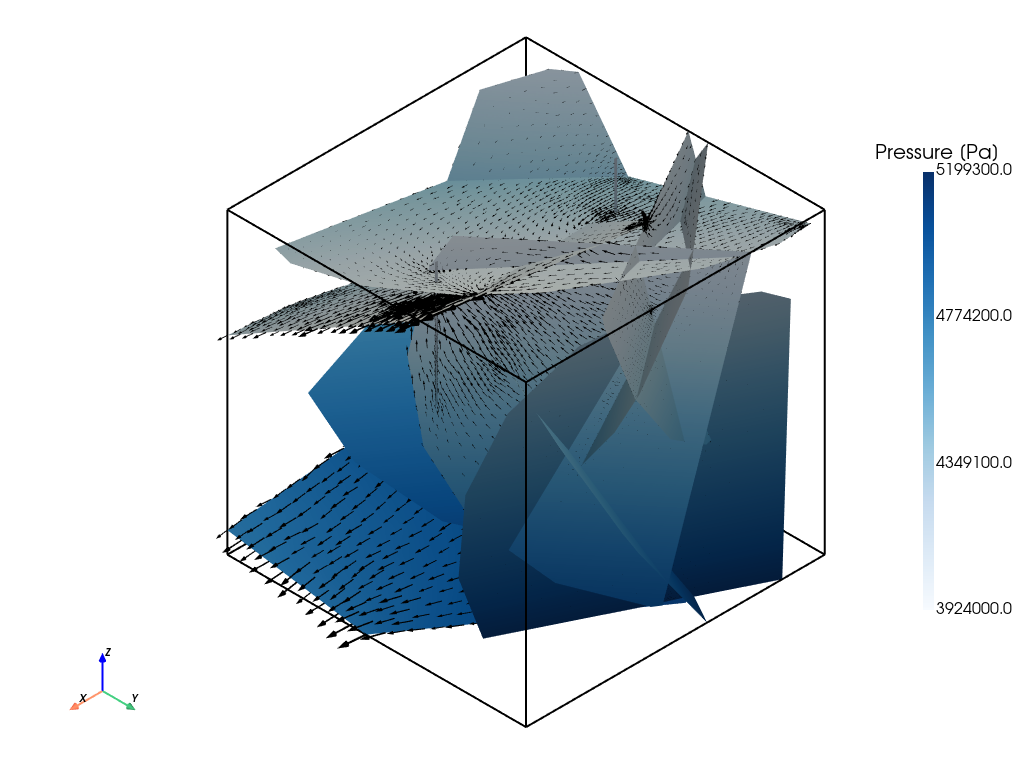

In [117]:
magnitude = np.linalg.norm(mesh["darcy_velocity"], axis=1)
magnitude[magnitude <= 0] = 1e-12
log_magnitude = np.log10(magnitude)
mesh["darcy_velocity_magnitude"] = magnitude
mesh["log_darcy_velocity_magnitude"] = log_magnitude
mesh.set_active_vectors("darcy_velocity")

vmax = magnitude.max()
domain_size = max(mesh.bounds[1::2]) - min(mesh.bounds[::2])
scale_factor = domain_size * 0.1 / vmax if vmax > 0 else 1.0

arrows = mesh.glyph(
    scale="darcy_velocity_magnitude", orient="darcy_velocity", factor=scale_factor
)
#arrows = mesh.glyph(
#    scale="darcy_velocity_magnitude", orient="darcy_velocity", factor=scale_factor
#)

plotter = pv.Plotter(off_screen=True)
scalar_bar_args["title"] = "Pressure [Pa]"
plotter.add_mesh(
    mesh,
    scalars="pressure",
    cmap="Blues",
    show_edges=False,
    opacity=1.0,
    scalar_bar_args=scalar_bar_args,
)
plotter.add_mesh(arrows, color="black", label="Velocity Vectors")
plotter.add_mesh(mesh.outline(), color="black", line_width=2)
plotter.show_axes()
plotter.enable_parallel_projection()
plotter.view_isometric()
output_path = out_dir.joinpath("full_mesh_velocity_log_arrows.png")
plotter.screenshot(str(output_path))
plotter.show()

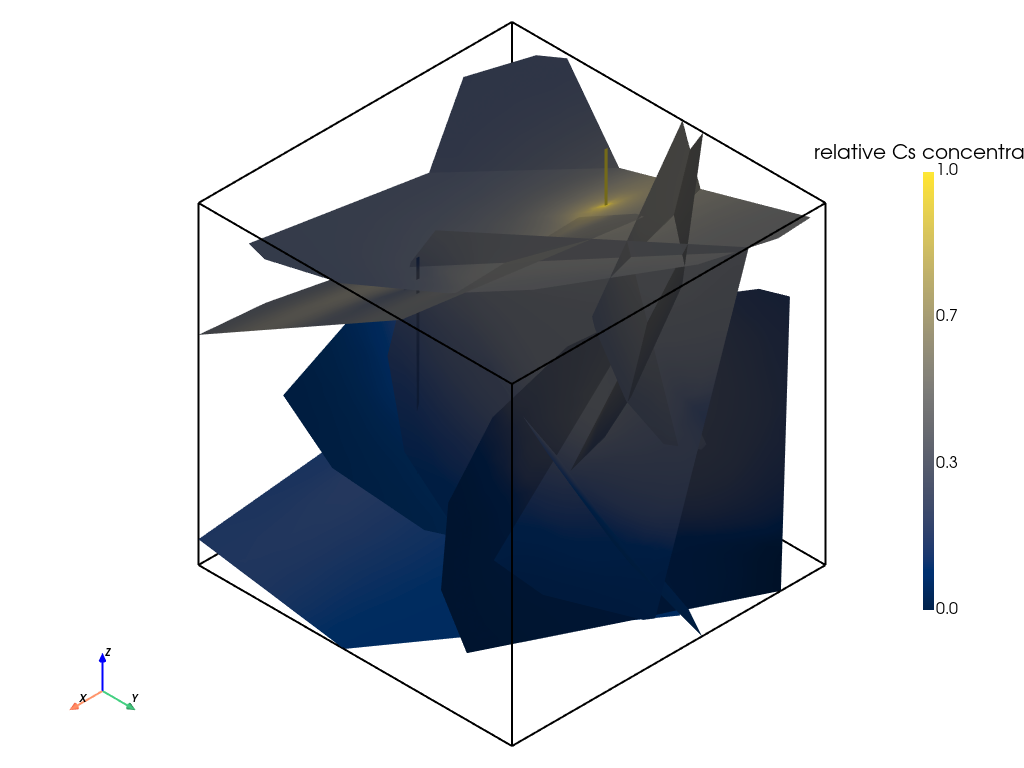

In [118]:
plotter = pv.Plotter(off_screen=True)
scalar_bar_args = base_scalar_bar_args.copy()
scalar_bar_args["title"] = "relative Cs concentration"

plotter.add_mesh(
    mesh,
    scalars="Cs",
    clim=(0, 1),
    cmap="cividis",
    show_edges=False,
    opacity=1.0,
    scalar_bar_args=scalar_bar_args,
)

plotter.add_mesh(mesh.outline(), color="black", line_width=2)
plotter.show_axes()
plotter.enable_parallel_projection()
plotter.view_isometric()
# plotter.window_size = [500, 500]
output_path = out_dir.joinpath("concentration_Cs.png")
plotter.screenshot(str(output_path))
plotter.show()

### Breakthrough curve (BTC)
the temporal evolution of tracer concentration at a downstream monitoring point in a flow-through porous medium,

Scalar fields available in mesh: ['Cs', 'OGS_VERSION', 'CsFlowRate', 'LiquidMassFlowRate', 'darcy_velocity', 'darcy_velocity_magnitude', 'log_darcy_velocity_magnitude', 'pressure', 'MaterialIDs', 'permeability_ic', 'porosity_avg', 'velocity', 'width_ic']


100%|███████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.17it/s]


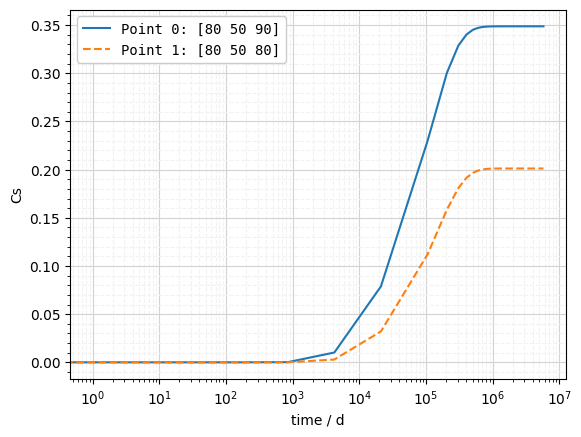

In [119]:
mesh_series = ot.MeshSeries(f'{out_dir}/{user_parameters["prefix"]}.pvd')
print("Scalar fields available in mesh:", mesh.array_names)

observation_points = np.array(
    [
        [80, 50, 90],
        [80, 50, 80],
    ]
)

labels = [f"Point {i}: {pt}" for i, pt in enumerate(observation_points)]


ms_days = mesh_series.scale(time=("s", "d"))
#var = ot.variables.Scalar("Si")
#fig_si = ms_days.plot_probe(points=observation_points, variable=var, labels=labels)
#fig_si.axes[0].set_xscale("log")

fig_cs = ms_days.plot_probe(points=observation_points, variable="Cs", labels=labels)
fig_cs.axes[0].set_xscale("log")

In [149]:
last_mesh = mesh_series[-1]
pressure_last = last_mesh.point_data["pressure"]

ref_mesh = pv.read("DFN_HC_ts_139_t_8640000000000.000000.vtu")
pressure_ref = ref_mesh.point_data["pressure"]

assert pressure_last.shape == pressure_ref.shape

np.testing.assert_allclose(actual=pressure_last, desired=pressure_ref, rtol=1e-10)

AssertionError: 

# References

1. **PorePy** – An open-source simulation tool for fractured and porous media. Available at: [https://github.com/pmgbergen/porepy](https://github.com/pmgbergen/porepy)

2. Keilegavlen, E., Berre, I., Fumagalli, A., Stefansson, I., and Edwards, M.G. (2021).  *PorePy: An open-source simulation tool for flow and transport in deformable fractured rocks.*  *Computational Geosciences*, 25, 165–187.

3. Buchwald, J., Kolditz, O., & Nagel, T. (2021). ogs6py and VTUinterface: streamlining OpenGeoSys workflows in Python. Journal of Open Source Software, 6(67), 3673.

4. Cvetkovic, V., & Frampton, A. (2010).  *Transport and retention from single to multiple fractures in crystalline rock at Äspö (Sweden): Fracture network simulations and generic retention model.*   *Water Resources Research*, 46, W05506.

5. Watanabe, N., & Kolditz, O. (2015). *Numerical stability analysis of two-dimensional solute transport along a discrete fracture in a porous rock matrix.* *Water Resources Research*, 51(7), 5855-5868.

6. Chen, C., Binder, M., Oppelt, L., Hu, Y., Engelmann, C., Arab, A., Xu, W., Scheytt, T., & Nagel, T. (2024). Modeling of heat and solute transport in a fracture-matrix mine thermal energy storage system and energy storage performance evaluation. Journal of Hydrology, 636(May), 131335.

7. Chen, R., Xu, W., Chen, Y., Nagel, T., Chen, C., Hu, Y., Li, J., & Zhuang, D. (2024). Influence of heterogeneity on dissolved CO2 migration in a fractured reservoir. Environmental Earth Sciences, 83(16), 463.
